Fluid Dynamics
==============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores fluid dynamics for image generation.

In [1]:
options(repr.plot.width=5, repr.plot.height=5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)
library(pracma)

source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")
source("nt_toolbox/meshgrid.R")

Loading required package: plyr
Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image


Attaching package: 'pracma'

The following objects are masked from 'package:magrittr':

    and, mod, or



Velocity Flow Field
-------------------
A velocity flow is simply a 2-D vector field $V = (V_i)_{i=1}^N \in \RR^{n \times n \times 2}$
where $V_i \in \RR^2$ is one of the $N=n \times n$ vectors at a position indexed by $i$.


It can be generated as a realization of Gaussian process.
The blurring creates correlations in the flow.

In [2]:
source("nt_toolbox/perform_blurring.R")

n <- 128
V <- perform_blurring( array( rnorm(n*n*2), c(n,n,2) ), c(40), "per" )

[1] 127 127
[1] 127 127
[1] 127 127
[1] 127 127


Subsampling display operator.

In [3]:
source("nt_toolbox/plot_vf.R")
myplot <- function(V){ plot_vf(V[seq(1,n,6),seq(1,n,6),]) }

We can display the vector field using arrow.

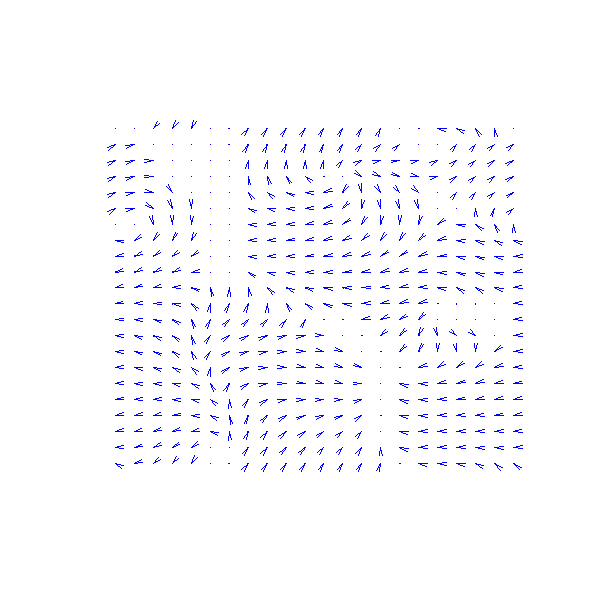

In [4]:
myplot(V)

We can renormalize the flow, which enhances the singularities. It defines
$\tilde V$ as $\tilde V_i = V_i/\norm{V_i}$.

In [5]:
normalize <- function(V){ V/ array(rep( pmax( array(1e-9, dim(V)[1:2]), sqrt(apply(V**2, c(1,2), sum)) ), 2 ), dim(V)) }

Display.

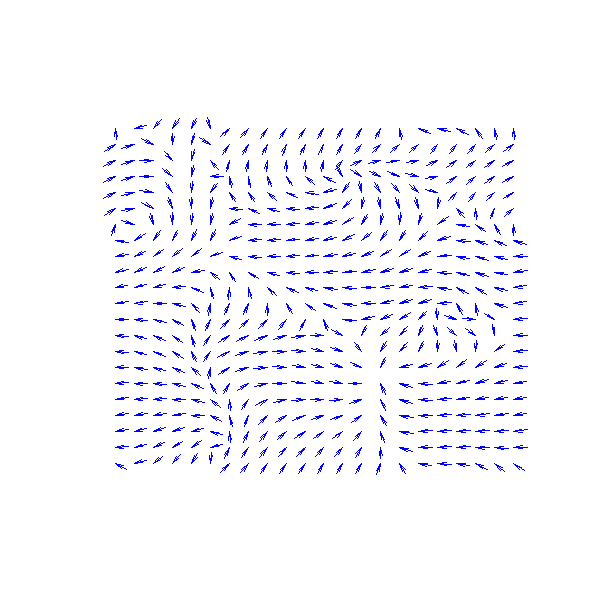

In [6]:
myplot(normalize(V))

Incompressible Flows
--------------------
An incompressible flow has a vanishing divergence. The set of vector
incompressible flow defines a sub-space of $\RR^{n \times n \times 2}$
$$ \Ii = \enscond{V}{ \text{div}(V)=0 }
  \qwhereq \text{div}(V) = \pd{V}{x_1} + \pd{V}{x_2} \in \RR^{n \times n}. $$
Here $\pd{}{x_s}$ for $s=1,2$ are finite differences approximation of
the horizontal and vertical derivative operators (we suppose here periodic boundary conditions).



The orthogonal projection $U = \text{Proj}_{\Ii}(V)$ on  $\Ii$ is
computed by solving a Poisson equation
$$ U = V-\nabla A \qwhereq \Delta A = \text{div}(V). $$


This is especially simple for periodic boundary conditions since $A$ can
be computed over the Fourier domain as
$$ \forall \om \neq 0, \quad \hat A(\om) = \frac{\hat Y(\om)}{\mu(\om)}
  \qwhereq Y = \text{div}(V) \qandq
  \mu(\om_1,\om_2) = -4 \sin(\om_1 \pi / n)^2 -4 \sin(\om_2 \pi / n)^2  $$
and $\hat A(0)=0$.



Compute the kernel $\mu(\om)$.

In [7]:
grid <- meshgrid_2d(0:(n-1), 0:(n-1))
Y <- grid$X ; X <- grid$Y
mu <- sin(X*pi/n)**2
mu <- -4*(mu + t(mu))
mu[1,1] <- 1

Computation of $A$.

In [8]:
source("nt_toolbox/div.R")

A <- function(V){ FFT <- fft( div(V[,,1], V[,,2], bound="per") )
                  return( Re( fft( FFT/mu, inverse=TRUE)/length(FFT) ) ) }

Projection on incompressible flows.

In [9]:
source("nt_toolbox/grad.R")

ProjI <- function(V){ V - grad(A(V), bound="per") }

Display $U=\text{Proj}_{\Ii}(V)$.

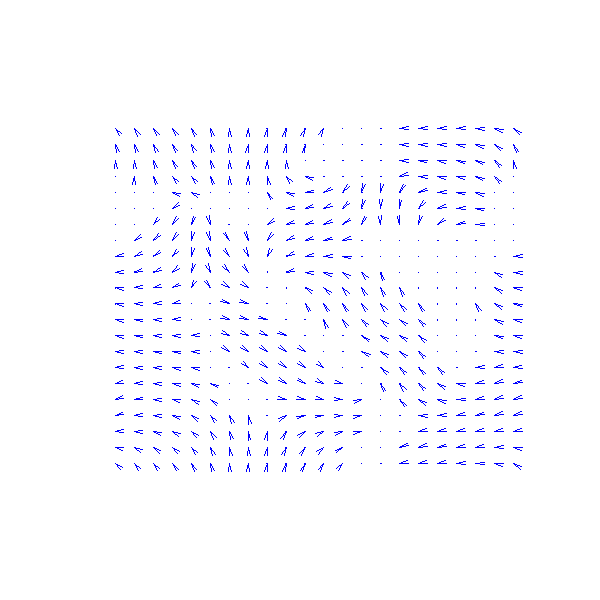

In [10]:
U <- ProjI(V)

myplot(U)

Display $W=U-V$ the irrotational component of $V$.

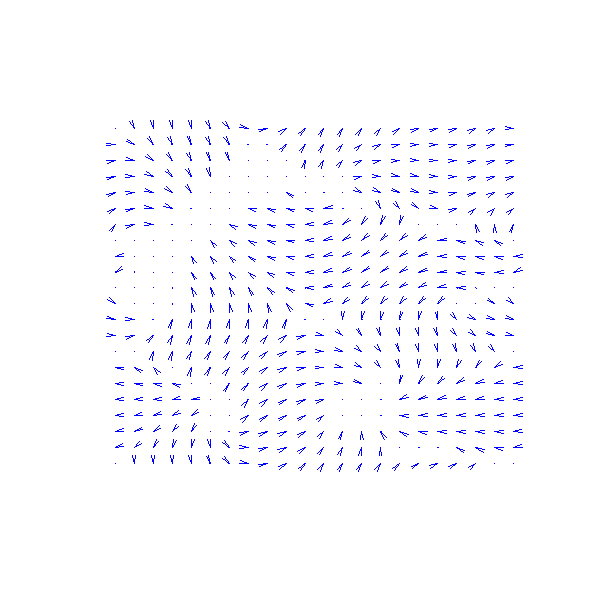

In [11]:
myplot(V-U)

Note that the decomposition $V=U+W$ is called the Hoge decomposition of
the vector field.


Image Advection Along the Flow
------------------------------
A flow defines a warping operator that transport the content of an image
along the streaming of the flow.


We load an image $f$.

In [12]:
f <- as.matrix(load_image("nt_toolbox/data/lena.png", 2*n))
f <- f[(n-round(n/2)+1):(n+round(n/2)),(n-round(n/2)+1):(n+round(n/2))]

Given some vector field $U$, the warping operator $f_1 = \Ww_U(f)$
along the flow is defined
$$ f_1(x) = f(x+U(x)) $$
i.e. it advects the values of $f$ by the vector field $U$ to obtain the values of $f_1$.


We define $U$ as a scaled normalized incompressible flow.

In [13]:
U <- normalize(ProjI(V))

Helper function: enforce periodicity.

In [14]:
periodic <- function(P){ mod(P,n) }

Helper function: extend an image by 1 pixel to avoid boundary problems.

In [15]:
extend1 <- function(f){ ext <- array(0, c(dim(f)[1], dim(f)[2]+1))
                        ext[,1:dim(f)[2]] <- f
                        ext[,dim(ext)[2]] <- f[,1]
                        return(ext) }

extend <- function(f){ t(extend1(t(extend1(f)))) }

Helper function: bilinear interpolation on a grid.

In [16]:
myinterp <- function(f1, Pi){
    dim_f1 <- dim(f1)
    f1 <- as.cimg(t(f1))
    locations <- data.frame(x=as.vector(Pi[,,2]), y=as.vector(Pi[,,1]))
    return( as.matrix(as.cimg(interp(f1, locations))) )
}

First we compute the initial and wraped grids.

In [17]:
grid <- meshgrid_2d(1:n, 1:n)
Y <- grid$X ; X <- grid$Y
P <- array(0, c(dim(X),2)) ; P[,,1] <- X ; P[,,2] <- Y

Defines the warping operator $\Ww_U$.

In [18]:
W <- function(f, U){ myinterp(extend(f), periodic(P - U)) }

Display a warped image $\Ww_{\rho U}(f)$ for some scaling $\rho$.

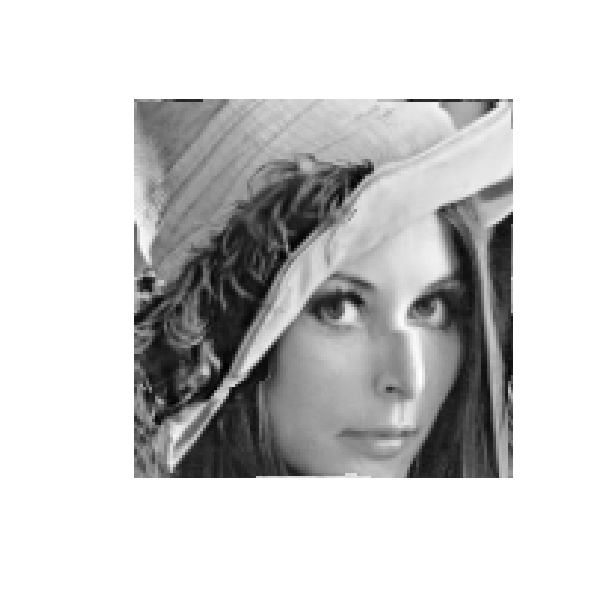

In [19]:
rho = 2
options(repr.plot.width=5, repr.plot.height=5)
imageplot(W(f, rho*U))

__Exercise 1__

Display $\Ww_{\rho U}(f)$ for various values of $\rho$.

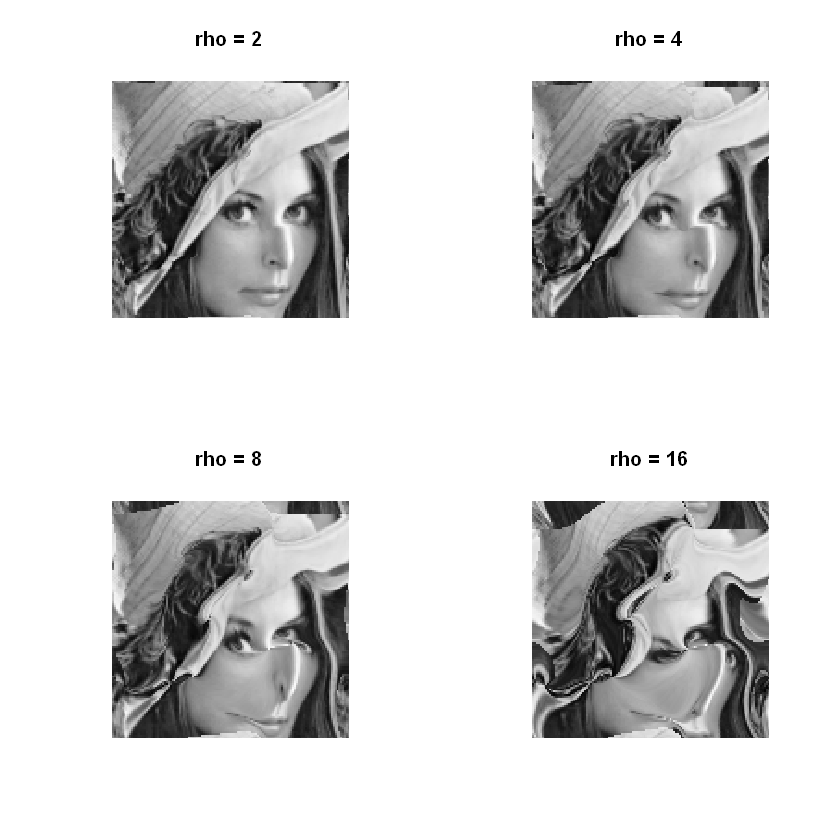

In [20]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/graphics_5_fluids/exo1.R")

In [21]:
## Insert your code here.

__Exercise 2__

Define an iterative scheme via:
$$ f^{(\ell+1)} = \Ww_{\rho U}(f^{(\ell)}).  $$
Display the result $f^{(\ell)}$, which corresponds approximately to solving
an advection equation at time $t=\ell \rho$.

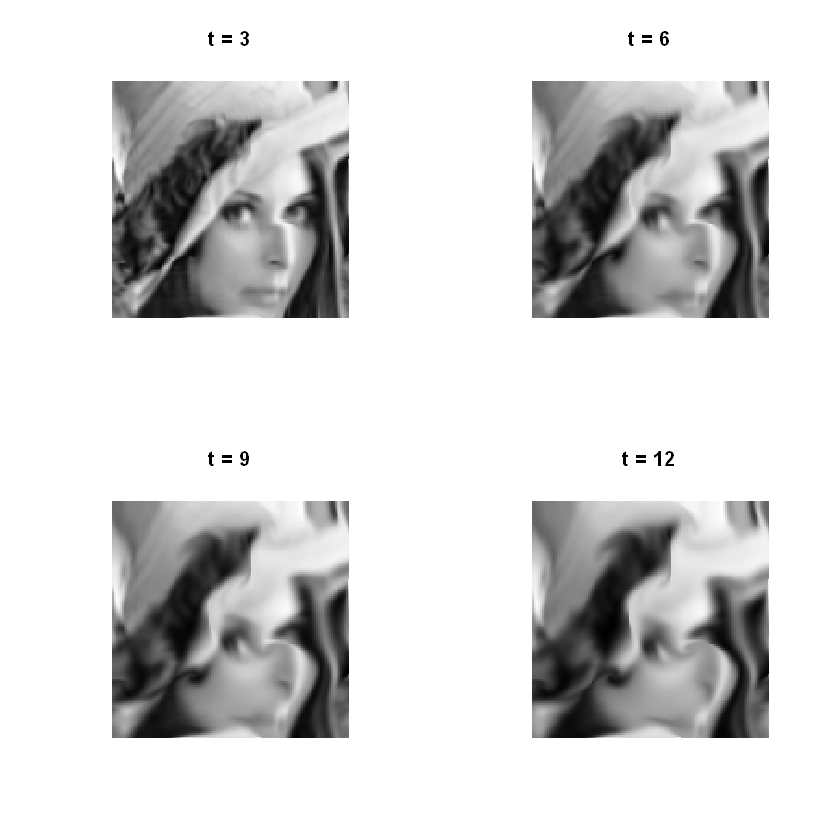

In [22]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/graphics_5_fluids/exo2.R")

In [23]:
## Insert your code here.

Fluid Dynamics
--------------
Fluid dynamics solves the incompressible Navier-Stokes equations to
evolve in time the vector field.


We discribe here a simple algorithm introduced in:


J. Stam, _Stable Fluids,_
SIGGRAPH'99, 1999, p. 121-128.


It proposes a semi-implicit scheme for the resolution of the Navier
Stockes equations for the movement of incompressible fluids
$$
      \pd{V}{t} =
      \text{Proj}_{\Ii}\pa{
          -(V \cdot \nabla) V + \nu \Delta V + W
      }.
$$
Here $\nu \geq 0$ is the viscosity of the fluid,
$W$ is a source term, $\Delta$ is the Laplacian, and
$-(V \cdot \nabla) V$ is the
non-linear self-advection, where we have used the short-hand
notation $V \cdot \nabla$ for the derivative operator along a flow $V$:
$$ (V \cdot \nabla)U = ( V_1 \pd{U_1}{x_1} + V_2 \pd{U_1}{x_2},
      V_1 \pd{U_2}{x_1} + V_2 \pd{U_2}{x_2} ).$$


In order to visualize the flow, we also advect and diffuse along the flow
a density $g$ of particules, which is a scalar field. Once $V$ has
been computed, it follows a linear PDE
$$
      \pd{g}{t} =
          -(V \cdot \nabla) g + \mu \Delta g + h
$$
with some initial condition at time $t=0$, where $h$ is a source for the density.


In practice, we solve this PDE in parallel to the PDE for $V$.


In the following, we use $W=0$ and $h=0$ (no sources).


Set the viscosity $\nu$ for the velocity field.

In [24]:
nu <- 1/10

We use a larger viscosity $\mu$ for the evolution of the density of
particules.

In [25]:
mu <- 2*nu

Extend the warping operator $\Ww_U$ to work with vector fields as input.
This will apply $\Ww_U$ on each channel of the vector field (X and Y coordinates).

In [26]:
Wt <- function(V, U){ x <- W(V[,,1],U)
                      y <- W(V[,,2],U)
                      out <- array(0, dim(V))
                      out[,,1] <- x ; out[,,2] <- y
                      return(out)}

We discretize the PDE's using some time step $\tau$.

In [27]:
tau <- .5

The algorithm computes $V^{(\ell)}$ at iteration $\ell$
which is an approximation of the PDE solution at time $\ell \tau$.
It is computed itertatively as
$$
      \tilde V^{(\ell)} = \Ww_{\tau V^{(\ell)}}( V^{(\ell)} )
  \qandq
      V^{(\ell+1)} = \text{Proj}_{\Ii}\pa{ \tilde V^{(\ell)} + \tau\nu\Delta \tilde V^{(\ell)} + \tau W  }
$$


It computes in parallel the evolution of the density as
$$
      \tilde g^{(\ell)} = \Ww_{\tau V^{(\ell)}}( g^{(\ell)} )
  \qandq
      g^{(\ell+1)} = \tilde g^{(\ell)} + \tau\nu\Delta \tilde g^{(\ell)} + \tau h
$$



Set the initial field $V=V^{(0)}$ at time $t=0$.

In [28]:
V <- normalize(ProjI(V))

Set the initial density $g=g^{(0)}$ at time $t=0$.

In [29]:
g <- f

The first step is to advect the vector field $V$ and $g$ along the flow $V$ itself.
This corresponds to an implict discretization of the term
$-(V \cdot \nabla) V$.

In [30]:
g <- W(g, tau*U)
V <- Wt(V, tau*U)

We implement the Laplacian using finite difference.

In [31]:
s1 <- c(2:n,1)
s2 <- c(n,1:(n-1))

Delta <- function(g){
    if (length(dim(g))==2) { 1/4.*(g[s1,] + g[s2,] + g[,s1] + g[,s2]) - g }
    else if (length(dim(g))==3) { 1/4.*(g[s1,,] + g[s2,,] + g[,s1,] + g[,s2,]) - g } }

The second step is to diffuse the vector field and the density.

In [32]:
V <- V + tau*nu*Delta(V)
g <- g + tau*mu*Delta(g)

The last step is to ensure incompressibility of $V$ by projecting on $\Ii$.

In [33]:
V <- ProjI(V)

__Exercise 3__

Compute the fluid dynamic by iterating these steps.

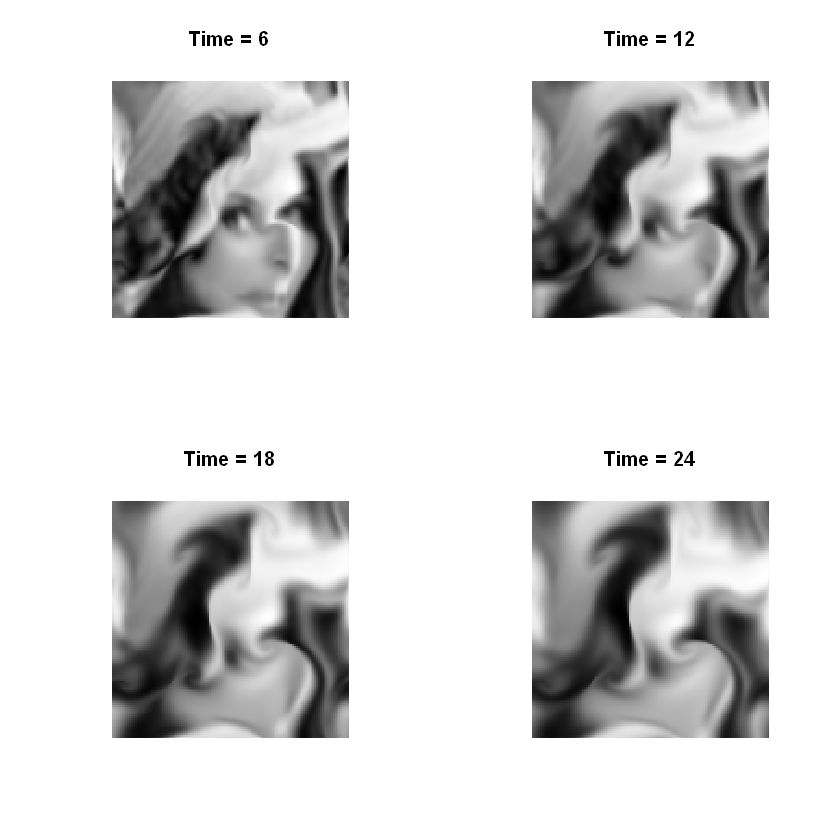

In [34]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/graphics_5_fluids/exo3.R")

In [35]:
## Insert your code here.

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>